In [745]:
import numpy as np
import pandas as pd
import lxml
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

## Lets get the stock market data over last year from yahoo

In [746]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table
df.head()
my_stocks = df['Symbol'].values.tolist()
n = len(my_stocks)
# my_stocks.remove('BRK.B')
# my_stocks.remove('BF.B')
my_stocks.remove('CARR')
my_stocks.remove('LUMN')
my_stocks.remove('OTIS')
my_stocks.remove('VNT')
my_stocks.remove('CTVA')
my_stocks.remove('FOXA')
my_stocks.remove('DOW')
my_stocks.remove('FOX')
my_stocks.remove('VIAC')


# my_stocks = ['ANSS', 'NDAQ', 'SPY', 'AMZN', 'AAPL', 'MSFT', 'FB', 'GOOG','NFLX','SPOT','SNE',
#              'TSLA', 'IBM', 'ADSK', 'MRNA', 'BNTX', 'AMGN','ABBV', 'GILD', 'BIIB', 'EW', 'DHR',
#              'WAT', 'BSX', 'DE', 'TM', 'CAT', 'MMM', 'GE', 'BA', 'EADSY', 'MAR', 'WYNN', 'CCL',
#              'DAL', 'NEE', 'JPM', 'GS', 'BAC', 'PYPL', 'V', 'FDX', 'SHW', 'ABT', 'EBAY', 'WORK',
#              'SNAP', 'PINS', 'TGT', 'TWTR', 'JNJ', 'COLM', 'HD', 'AZN', 'CRM', 'APPN', 
#               'NIO', 'REGI', 'CSIQ', 'FTNT', 'PPLT', 'THC', 'CORT', 'HNGR', 'NXGN', 'EOG', 
#              'UNH', 'CVS', 'HTH', 'OMF', 'DHT', 'BBY', 'GLD' ]

# my_stocks.remove('BNTX')
# my_stocks.remove('WORK')
# my_stocks.remove('PINS')
# my_stocks.remove('SPOT')
# my_stocks.remove('MRNA')
# my_stocks.remove('NIO')

trade_freq = 2


In [747]:
import urllib.request

print('Downloading data...')

for symbol in my_stocks:
    url2020 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1577836800&period2=1611014400&interval=1d&events=history&includeAdjustedClose=true'
    url2019 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1546300800&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'
    url2018 = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1514764800&period2=1611014400&interval=1d&events=history&includeAdjustedClose=true'
    
    urllib.request.urlretrieve(url2018,symbol+'.csv')
    

## Now read the data using pandas

In [748]:
my_dict = {}
import os
for symbol in my_stocks:
    my_dict[symbol] = pd.read_csv(symbol+'.csv')
    os.remove(symbol+'.csv')

n = len(my_dict)
T_all = my_dict['AAPL'].shape[0]

my_dict['AAPL'].tail()

,Date,Open,High,Low,Close,Adj Close,Volume
761,2021-01-11,129.190002,130.169998,128.500000,128.979996,128.979996,100620900
762,2021-01-12,128.500000,129.690002,126.860001,128.800003,128.800003,91951100
763,2021-01-13,128.759995,131.449997,128.490005,130.889999,130.889999,88636800
764,2021-01-14,130.800003,131.000000,128.759995,128.910004,128.910004,90221800
765,2021-01-15,128.779999,130.220001,127.000000,127.139999,127.139999,111598500


In [754]:
all_stocks = np.zeros([n,T_all])
for i, symbol in enumerate(my_stocks):
    try:
        all_stocks[i,:] =  np.float32(my_dict[symbol].Open)/2 
    except:
        print("some problem for data of",symbol)
all_times =  my_dict[symbol].Date

stocks = all_stocks[:,::trade_freq]
times = all_times.iloc[::trade_freq]
T = len(stocks[0])

## Online newton step algorithm and expert

In [755]:
x = np.ones(n)/n
f = np.zeros(T)

# Parameter Free Expert
sum_g_tild = np.zeros(n)
sum_g_w = np.zeros(n)
x_0 = np.ones(n)/n
for t in range(T-1):

    w = sum_g_tild /(t+T/2)*(1+sum_g_w)
    x = x_0 * np.maximum(w, 0)

    if np.sum(x) > 0:
        x = x / np.sum(x)
    else:
        x = x_0

    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = r/np.dot(x, r)

    g_tild = grad - np.dot(grad, x)
    g_tild[w<0] = np.maximum(g_tild[w<0], 0)

    sum_g_tild += g_tild
    sum_g_w += g_tild

log_wealth_expert = np.cumsum(-f)

x_pfe = x
biggest = np.argsort(x)
print('PFE portfolio')
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_pfe[i]*100))+ '%')

PFE portfolio
ENPH	14.164%
TSLA	6.117%
ETSY	3.242%
AMD	3.037%
DXCM	2.045%
PAYC	1.314%
FCX	1.291%
LB	1.264%
CMG	1.253%
NCLH	1.128%
APA	1.093%
MGM	1.067%
HAL	0.9985%
NVDA	0.919%
FANG	0.914%
RCL	0.9014%
GPS	0.885%
TER	0.883%
APTV	0.875%
NOW	0.8037%
ALGN	0.7964%
ZBRA	0.781%
LRCX	0.7285%
DRI	0.7246%
DFS	0.6987%
ALB	0.679%
FTNT	0.6694%
PVH	0.6675%
CDNS	0.6367%
MKTX	0.5967%
CTLT	0.5947%
KEYS	0.594%
WST	0.5854%
MSCI	0.5815%
QRVO	0.5693%
TPR	0.5596%
IVZ	0.5503%
QCOM	0.5435%
SIVB	0.525%
OXY	0.524%
DVN	0.511%
MOS	0.5015%
AAPL	0.497%
SNPS	0.483%
IDXX	0.482%
KLAC	0.4802%
URI	0.4795%
DXC	0.478%
PYPL	0.4705%
POOL	0.466%
CCL	0.4602%
EXPE	0.4502%
AMAT	0.4417%
HWM	0.4414%
LNC	0.4365%
ADSK	0.4363%
TGT	0.423%
UAL	0.4216%
FTI	0.41%
DVA	0.399%
VTR	0.3953%
WYNN	0.3938%
MRO	0.3723%
UAA	0.3594%
MU	0.3574%
NFLX	0.346%
CPRT	0.332%
PWR	0.3293%
ABMD	0.3203%
UA	0.3193%
TWTR	0.3162%
OKE	0.3152%
GM	0.3108%
AMZN	0.3062%
LYB	0.3005%
SYF	0.296%
NOV	0.2954%
EMN	0.2922%
BLL	0.291%
AAL	0.2888%
ADBE	0.2852%
FITB	0.2844%
CMA

In [756]:
def project(y, A):
    n = y.size

    P = matrix(A, tc='d')
    q = matrix(-2*np.matmul(y, A), tc='d')
    G = matrix(-np.eye(n), tc='d')
    h = matrix(np.zeros(n), tc='d')
    A = matrix(np.ones([1,n]), tc='d')
    b = matrix([1], tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    return np.array(sol['x']).reshape(-1)

In [757]:
# ONS
alpha = 0.5
G = np.sqrt(n)/alpha
gamma = 1/8/G
epsilon = 1/gamma**2
# gamma = 1
# epsilon = 1/8

# Initialization
A = epsilon*np.eye(n)
x = np.ones(n)/n
f = np.zeros(T)

# Algorithms
for t in range(T-1):
    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = - r/np.dot(x, r)

    # ONS
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

log_wealth_ons = np.cumsum(-f)

x_ons = x

print('ONS portfolio')
biggest = np.argsort(x)
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_ons[i]*100))+ '%')

ONS portfolio
AMD	100.0%
ETSY	6e-08%
OXY	6e-08%
REG	0.0%
GM	0.0%
APA	0.0%
SPG	0.0%
COO	0.0%
CINF	0.0%
LKQ	0.0%
DAL	0.0%
NRG	0.0%
UAA	0.0%
DTE	0.0%
UDR	0.0%
EVRG	0.0%
HST	0.0%
COG	0.0%
PYPL	0.0%
MRO	0.0%
PEAK	0.0%
TRV	0.0%
ALK	0.0%
SYF	0.0%
UNM	0.0%
TDY	0.0%
WELL	0.0%
HAL	0.0%
EBAY	0.0%
DISCK	0.0%
SRE	0.0%
LMT	0.0%
NCLH	0.0%
CF	0.0%
FDX	0.0%
EQR	0.0%
PNR	0.0%
VTR	0.0%
IVZ	0.0%
CMA	0.0%
LRCX	0.0%
ARE	0.0%
HBI	0.0%
XRAY	0.0%
CTXS	0.0%
AMAT	0.0%
BXP	0.0%
WLTW	0.0%
COP	0.0%
NEE	0.0%
TSCO	0.0%
LHX	0.0%
WMB	0.0%
ANET	0.0%
VNO	0.0%
PPG	0.0%
DVN	0.0%
FBHS	0.0%
EIX	0.0%
PRGO	0.0%
APD	0.0%
MCHP	0.0%
HIG	0.0%
DUK	0.0%
BBY	0.0%
UA	0.0%
WEC	0.0%
ESS	0.0%
NLSN	0.0%
HAS	0.0%
PEG	0.0%
AON	0.0%
FLT	0.0%
ZBH	0.0%
COF	0.0%
FMC	0.0%
SIVB	0.0%
LOW	0.0%
BEN	0.0%
EXC	0.0%
WBA	0.0%
PBCT	0.0%
AVB	0.0%
NOC	0.0%
PFG	0.0%
DE	0.0%
RL	0.0%
GS	0.0%
HSIC	0.0%
SLG	0.0%
SBAC	0.0%
CI	0.0%
MAA	0.0%
CXO	0.0%
AOS	0.0%
FE	0.0%
XOM	0.0%
EXPD	0.0%
PSA	0.0%
LW	0.0%
ED	0.0%
CERN	0.0%
FCX	0.0%
CMI	0.0%
CFG	0.0%
LYV	0.0%
CB	0.0%
F

## Backtest results

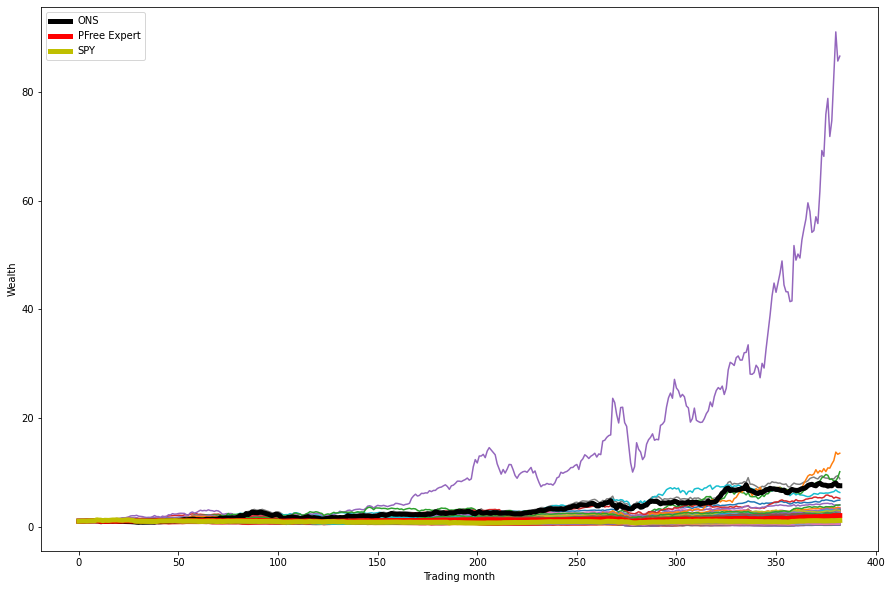

In [758]:
# Visualization
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
# ali = times.to_numpy()
# xtimes = [ali[i][2:4]+'/'+ali[i][5:-3] for i in range(len(times))]
for i, symbol in enumerate(my_stocks):
    ax.plot(range(T),np.exp(np.log(stocks[i,:]) - np.log(stocks[i,0])))

ax.plot(range(T), np.exp(log_wealth_ons ), 'k' , linewidth=5, label='ONS')
ax.plot(range(T), np.exp(log_wealth_expert ), 'r' , linewidth=5, label='PFree Expert')
ax.plot(range(T), np.exp(np.log(stocks[2,:])- np.log(stocks[2,0])), 'y' , linewidth=5, label='SPY')

ax.legend()
ax.set_xlabel('Trading month')
ax.set_ylabel('Wealth')
plt.show()
